<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/2.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,4.011808
1,4.016080
2,3.993376
3,3.981656
4,3.996736
...,...
38875,7.981184
38876,7.982088
38877,7.980072
38878,7.974312


<AxesSubplot: >

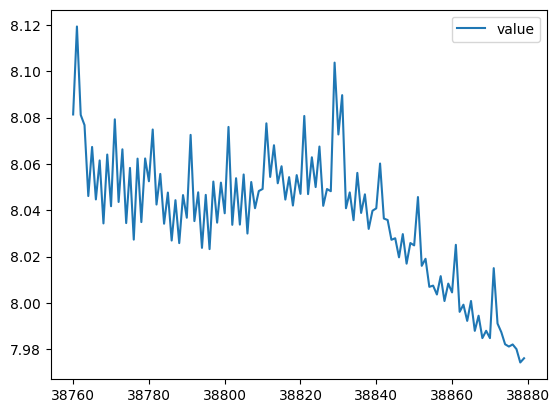

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_584256/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 8.178077074038736 %
smape 5.484803254057092 %
smape 2.649032817887992 %
smape 1.142591527405832 %
smape 0.9841008110064468 %
smape 0.9668549452091387 %
smape 0.8944681140441687 %
smape 0.8867263604072603 %
smape 0.9174644862293478 %
smape 0.8152518592698619 %
smape 0.8620472033562585 %
smape 0.958639295031017 %
smape 0.9419131453614681 %
smape 0.8441610399113522 %
smape 0.7685123497691028 %
smape 0.7452689657431663 %
smape 0.7050445796077668 %
smape 0.6409843220193027 %
smape 0.619467921624483 %
smape 0.5947806551978972 %
smape 0.6025417349151505 %
smape 0.6044376205328895 %
smape 0.5862396686577527 %
smape 0.5733696147200396 %
smape 0.5548045837677121 %
smape 0.554189063759782 %
smape 0.5551816788924129 %
smape 0.5523809884832791 %
smape 0.5475170541573752 %
smape 0.5489395145525644 %
smape 0.5456259925522956 %
smape 0.5372811594980699 %
smape 0.540254474998784 %
smape 0.5406206659564192 %
smape 0.5342709673609454 %
smape 0.5354331003649062 %
smape 0.5371169301365333 %
smape 0.5

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.08835571449708368 %
SMAPE 0.02179788487001133 %
SMAPE 0.03321459633343693 %
SMAPE 0.16365219401177455 %
SMAPE 0.01779008549340233 %
SMAPE 0.056075832451256254 %
SMAPE 0.11448943228378995 %
SMAPE 0.07532789965654274 %
SMAPE 0.019916039172585442 %
SMAPE 0.014255132456810314 %
SMAPE 0.0038835578306475327 %
SMAPE 0.0832640079960072 %
SMAPE 0.02090905826207745 %
SMAPE 0.08271545742388753 %
SMAPE 0.013393497207204064 %
SMAPE 0.04913224723827624 %
SMAPE 0.05662437711690415 %
SMAPE 0.21322063518732648 %
SMAPE 0.08230312288196728 %
SMAPE 0.053645614298602595 %
SMAPE 0.23520847053350738 %
SMAPE 0.017662503949097186 %
SMAPE 0.051336320688392334 %
SMAPE 0.046176725944405916 %
SMAPE 0.08971194638638735 %
SMAPE 0.03842967186960777 %
SMAPE 0.05640867920214987 %
SMAPE 0.09003872996254358 %
SMAPE 0.11866350843888541 %
SMAPE 0.04917321936136432 %
SMAPE 0.04020075621701835 %
SMAPE 0.02707602080772631 %
SMAPE 0.10224076540055194 %
SMAPE 0.07401483790044949 %
SMAPE 0.035252888808145144 %
SMAPE 0.07

SMAPE 0.002977596135906424 %
SMAPE 0.01447632693907508 %
SMAPE 0.007163646862700545 %
SMAPE 0.007026185971426457 %
SMAPE 0.007463183185336675 %
SMAPE 0.003342148771992015 %
SMAPE 0.008438315393533458 %
SMAPE 0.009808844051505616 %
SMAPE 0.05352983461489202 %
SMAPE 0.09145577173785568 %
SMAPE 0.020677357348048986 %
SMAPE 0.021916198838198397 %
SMAPE 0.007461106942628248 %
SMAPE 0.06280931123671962 %
SMAPE 0.009665289856172876 %
SMAPE 0.03231041745853247 %
SMAPE 0.007900337827862813 %
SMAPE 0.008942152988765883 %
SMAPE 0.002309051429890019 %
SMAPE 0.002333088775039016 %
SMAPE 0.03724890707485429 %
SMAPE 0.005727892738505602 %
SMAPE 0.005831191021172799 %
SMAPE 0.0197733917923415 %
SMAPE 0.00946656823862213 %
SMAPE 0.01635008788389314 %
SMAPE 0.006535611588788014 %
SMAPE 0.01931189264735167 %
SMAPE 0.002642871572504646 %
SMAPE 0.03469750041794839 %
SMAPE 0.025601970052548495 %
SMAPE 0.021291999525402616 %
SMAPE 0.030235645120683326 %
SMAPE 0.02184580944327763 %
SMAPE 0.009050228268506544 

SMAPE 0.0032636974521551565 %
SMAPE 0.0016175672453755396 %
SMAPE 0.009763477685282851 %
SMAPE 0.026974982964020452 %
SMAPE 0.01218707433650934 %
SMAPE 0.014336383400973318 %
SMAPE 0.005050072286508112 %
SMAPE 0.008892704938460838 %
SMAPE 0.008812674389901076 %
SMAPE 0.0089535222828232 %
SMAPE 0.02436647449438567 %
SMAPE 0.016107675555872447 %
SMAPE 0.013678435496160544 %
SMAPE 0.019181351156845494 %
SMAPE 0.005602491950902788 %
SMAPE 0.01716808659932667 %
SMAPE 0.024184609416579406 %
SMAPE 0.053728581988025326 %
SMAPE 0.00925439742763956 %
SMAPE 0.011179695868577255 %
SMAPE 0.0023436530739076034 %
SMAPE 0.00283552422001776 %
SMAPE 0.008047408619034968 %
SMAPE 0.005124692499244077 %
SMAPE 0.0020028714136088865 %
SMAPE 0.005671964032529786 %
SMAPE 0.008091471346887147 %
SMAPE 0.004770146987141288 %
SMAPE 0.013652051207088789 %
SMAPE 0.07078186233343331 %
SMAPE 0.034420098934901944 %
SMAPE 0.009509786263947717 %
SMAPE 0.006166299180478063 %
SMAPE 0.010101295981627345 %
SMAPE 0.0112976359

SMAPE 0.009256419001332006 %
SMAPE 0.01090996458066229 %
SMAPE 0.0016581442771155253 %
SMAPE 0.06331739445136009 %
SMAPE 0.007426699509153422 %
SMAPE 0.02956677148594622 %
SMAPE 0.02637491264141545 %
SMAPE 0.012451830025838717 %
SMAPE 0.004594423624354249 %
SMAPE 0.006007169051429173 %
SMAPE 0.00487755036397175 %
SMAPE 0.004864817219242923 %
SMAPE 0.023223742751724785 %
SMAPE 0.0022299884064693742 %
SMAPE 0.04173411711906283 %
SMAPE 0.007715127271993083 %
SMAPE 0.017382159042469425 %
SMAPE 0.001481248793083978 %
SMAPE 0.017245691958692078 %
SMAPE 0.002078232616398168 %
SMAPE 0.0014522377753536375 %
SMAPE 0.0019843506584322768 %
SMAPE 0.005605967338681239 %
SMAPE 0.011052674981385735 %
SMAPE 0.024845300886376265 %
SMAPE 0.004807327737637479 %
SMAPE 0.0017403069950816532 %
SMAPE 0.056101589167610655 %
SMAPE 0.06782901154110732 %
SMAPE 0.01632372413823191 %
SMAPE 0.1195605316579531 %
SMAPE 0.10791659232189232 %
SMAPE 0.011549215040147942 %
SMAPE 0.03227969218576732 %
SMAPE 0.0765664134985

SMAPE 0.002786204958738381 %
SMAPE 0.0016976024012933522 %
SMAPE 0.013213636828766084 %
SMAPE 0.008040640267154231 %
SMAPE 0.015149582277160789 %
SMAPE 0.01647996442193289 %
SMAPE 0.00938310785181784 %
SMAPE 0.002652628103760435 %
SMAPE 0.005496758195633333 %
SMAPE 0.009294021202208569 %
SMAPE 0.004965126780561491 %
SMAPE 0.04951763189257008 %
SMAPE 0.010545232031276441 %
SMAPE 0.0077669371623372285 %
SMAPE 0.002523967441149466 %
SMAPE 0.01955236710367103 %
SMAPE 0.0150045739367215 %
SMAPE 0.018662118148355944 %
SMAPE 0.006803772011757303 %
SMAPE 0.015873213354694826 %
SMAPE 0.009372205587126814 %
SMAPE 0.00643159185665354 %
SMAPE 0.04720937968954786 %
SMAPE 0.009196612609343902 %
SMAPE 0.007893987907380051 %
SMAPE 0.006847657466835244 %
SMAPE 0.031643070074778734 %
SMAPE 0.023335270828624743 %
SMAPE 0.024319439241054397 %
SMAPE 0.006370969356112255 %
SMAPE 0.012662123294603589 %
SMAPE 0.00750781402197731 %
SMAPE 0.003638703922625553 %
SMAPE 0.038560373344807886 %
SMAPE 0.0161638567044

SMAPE 0.007653702641690074 %
SMAPE 0.001858883032937797 %
SMAPE 0.006339068455417874 %
SMAPE 0.0015298206558682637 %
SMAPE 0.023635366694179538 %
SMAPE 0.004137535559038952 %
SMAPE 0.0059668139149380295 %
SMAPE 0.011410571960595917 %
SMAPE 0.010358266849664233 %
SMAPE 0.03525083874922075 %
SMAPE 0.002956124450633979 %
SMAPE 0.003295151945735597 %
SMAPE 0.01191496523921387 %
SMAPE 0.01408456687437365 %
SMAPE 0.012798796869731177 %
SMAPE 0.009272583590799854 %
SMAPE 0.023275393566407843 %
SMAPE 0.004113384454186075 %
SMAPE 0.018797579907108286 %
SMAPE 0.019581327577839147 %
SMAPE 0.01617071831691419 %
SMAPE 0.0037070115197934683 %
SMAPE 0.030774876314211497 %
SMAPE 0.007519301273873679 %
SMAPE 0.0024111399517892096 %
SMAPE 0.0013703542588316964 %
SMAPE 0.002668216734896589 %
SMAPE 0.005849321098139626 %
SMAPE 0.012219424957265801 %
SMAPE 0.009319855336208605 %
SMAPE 0.0034162940938102793 %
SMAPE 0.0092587848301946 %
SMAPE 0.0015520551194185828 %
SMAPE 0.0035506436238961214 %
SMAPE 0.0233

SMAPE 0.0024989346777601895 %
SMAPE 0.02908050790682637 %
SMAPE 0.007809910972525813 %
SMAPE 0.0032588673093130183 %
SMAPE 0.018688706159366575 %
SMAPE 0.0014737536467350765 %
SMAPE 0.006716663207100736 %
SMAPE 0.009677771216416886 %
SMAPE 0.008922934404836269 %
SMAPE 0.003012252939399218 %
SMAPE 0.013391957515921149 %
SMAPE 0.012508008530218717 %
SMAPE 0.012564563207661195 %
SMAPE 0.005821785316669548 %
SMAPE 0.014747367977513193 %
SMAPE 0.003513858541353443 %
SMAPE 0.009314764193703695 %
SMAPE 0.02714868634095069 %
SMAPE 0.016043799297847272 %
SMAPE 0.008394034891068713 %
SMAPE 0.003273346881883299 %
SMAPE 0.016742890022896972 %
SMAPE 0.010936684013586273 %
SMAPE 0.0006244519713618502 %
SMAPE 0.01937634397165766 %
SMAPE 0.007193322009598547 %
SMAPE 0.0025207050257449737 %
SMAPE 0.004137831966843919 %
SMAPE 0.04556783402790643 %
SMAPE 0.005648377785973935 %
SMAPE 0.02138502797276942 %
SMAPE 0.020442351230485656 %
SMAPE 0.015508334313182104 %
SMAPE 0.01596140167004023 %
SMAPE 0.0044362

SMAPE 0.035754489388210686 %
SMAPE 0.04430323734186459 %
SMAPE 0.0046446034943414816 %
SMAPE 0.008421435626644325 %
SMAPE 0.0010991690606516613 %
SMAPE 0.004412750158031997 %
SMAPE 0.010005294660800246 %
SMAPE 0.01581951345335142 %
SMAPE 0.004897269987964137 %
SMAPE 0.004540495955325241 %
SMAPE 0.013621764980825901 %
SMAPE 0.00903890075039726 %
SMAPE 0.05172992087194217 %
SMAPE 0.03990702663196544 %
SMAPE 0.008208148382891522 %
SMAPE 0.010188177471640358 %
SMAPE 0.00394913839977562 %
SMAPE 0.010209025894013735 %
SMAPE 0.01334585702612401 %
SMAPE 0.027727048534273987 %
SMAPE 0.003960702638636349 %
SMAPE 0.005309588602841586 %
SMAPE 0.0010304913085477097 %
SMAPE 0.025294960553935653 %
SMAPE 0.006220758249369851 %
SMAPE 0.011117427653431378 %
SMAPE 0.011338361274624731 %
SMAPE 0.004117474707399538 %
SMAPE 0.014597222590396086 %
SMAPE 0.003460305257078744 %
SMAPE 0.00654909355756672 %
SMAPE 0.011715759142688853 %
SMAPE 0.024727516078542067 %
SMAPE 0.001190461899255979 %
SMAPE 0.03865248369

SMAPE 0.018620299402243745 %
SMAPE 0.014768408958190093 %
SMAPE 0.004821363662017575 %
SMAPE 0.007787267660432916 %
SMAPE 0.004042076698645758 %
SMAPE 0.0005677276683400123 %
SMAPE 0.03454397877419524 %
SMAPE 0.010997100913726854 %
SMAPE 0.005003931022962149 %
SMAPE 0.002046870587477656 %
SMAPE 0.006346774394870636 %
SMAPE 0.035122247038998466 %
SMAPE 0.017768030719054195 %
SMAPE 0.0066320157777681734 %
SMAPE 0.011111418536870588 %
SMAPE 0.00851104029165839 %
SMAPE 0.007769817121527467 %
SMAPE 0.009170298081016881 %
SMAPE 0.034993573393933275 %
SMAPE 0.04121336396984532 %
SMAPE 0.0058467973402756 %
SMAPE 0.028370109837965174 %
SMAPE 0.00941667162276616 %
SMAPE 0.006615446541218262 %
SMAPE 0.004829889603229276 %
SMAPE 0.01670646134505205 %
SMAPE 0.004395582821530297 %
SMAPE 0.009523425973895883 %
SMAPE 0.0042704422855877056 %
SMAPE 0.0024226905418913702 %
SMAPE 0.001386090891458025 %
SMAPE 0.011841957829432204 %
SMAPE 0.013839023747721056 %
SMAPE 0.02325789369638187 %
SMAPE 0.0631253230

SMAPE 0.008855283938828507 %
SMAPE 0.03422560983574385 %
SMAPE 0.04161581542439308 %
SMAPE 0.15721016228053486 %
SMAPE 0.5835727785647578 %
SMAPE 0.4566021321554672 %
SMAPE 0.13249032235023606 %
SMAPE 1.616369639938057 %
SMAPE 0.03478062460914089 %
SMAPE 0.013947697322407748 %
SMAPE 0.06840965380001762 %
SMAPE 0.26660480545797327 %
SMAPE 0.3462819708884126 %
SMAPE 0.37901995516585885 %
SMAPE 0.3097368649114287 %
SMAPE 0.22316281204257396 %
SMAPE 0.12964277676610436 %
SMAPE 0.14573921265781564 %
SMAPE 0.8360638206831937 %
SMAPE 0.8787214737276372 %
SMAPE 0.006542713605767859 %
SMAPE 0.1502317047629731 %
SMAPE 0.5739494157011222 %
SMAPE 0.39148059445687977 %
SMAPE 0.007779621400686664 %
SMAPE 0.014968409081120626 %
SMAPE 0.005355798741675244 %
SMAPE 0.33374711077885877 %
SMAPE 0.4864346684444172 %
SMAPE 0.48885889615712586 %
SMAPE 0.09048343882932386 %
SMAPE 0.05328592493765427 %
SMAPE 1.4998133700464678 %
SMAPE 1.4247705693778698 %
SMAPE 0.622355385496121 %
SMAPE 0.38559179405092436 %
S

SMAPE 0.5417250732219827 %
SMAPE 0.009838515851086527 %
SMAPE 0.08935534937381817 %
SMAPE 0.09160139013374646 %
SMAPE 0.07080629313925613 %
SMAPE 0.12053288569489952 %
SMAPE 0.05125407349919442 %
SMAPE 0.06083001004986954 %
SMAPE 0.025618934044132406 %
SMAPE 0.219497064918869 %
SMAPE 0.281892382195565 %
SMAPE 0.013072862612489189 %
SMAPE 0.046347112410103364 %
SMAPE 0.05885136599033559 %
SMAPE 0.0836356364693529 %
SMAPE 0.18339097845318975 %
SMAPE 0.10033191188212243 %
SMAPE 0.0455256536791353 %
SMAPE 0.1320563382855653 %
SMAPE 0.0770062078720457 %
SMAPE 0.35197884058902673 %
SMAPE 0.019610255020666045 %
SMAPE 0.06257519926430177 %
SMAPE 0.04177110040836851 %
SMAPE 0.04047191735887168 %
SMAPE 0.18977819404585716 %
SMAPE 0.05424544672354159 %
SMAPE 0.07612651565409578 %
SMAPE 0.04574957360580356 %
SMAPE 0.12025327614719572 %
SMAPE 0.3055370510649027 %
SMAPE 0.04038288077595098 %
SMAPE 0.07483330578645564 %
SMAPE 0.0963513320035645 %
SMAPE 0.018798457139041602 %
SMAPE 0.216166806043816 %

SMAPE 0.011585746847543987 %
SMAPE 0.005788056904350469 %
SMAPE 0.015281897119621135 %
SMAPE 0.05673282540897163 %
SMAPE 0.009853510710797764 %
SMAPE 0.06273805413542277 %
SMAPE 0.026163743553979657 %
SMAPE 0.013005383442774132 %
SMAPE 0.06790070067970788 %
SMAPE 0.08919189773831704 %
SMAPE 0.0032301537798957725 %
SMAPE 0.00808249399642591 %
SMAPE 0.0025420887087648225 %
SMAPE 0.03709095369188731 %
SMAPE 0.015338380540441676 %
SMAPE 0.027044535535878822 %
SMAPE 0.008597498499113954 %
SMAPE 0.0011807684183224865 %
SMAPE 0.10799815588961792 %
SMAPE 0.07415745270839125 %
SMAPE 0.006200949690537527 %
SMAPE 0.006046539341355128 %
SMAPE 0.013909549760001026 %
SMAPE 0.03828027746135376 %
SMAPE 0.023295141802691433 %
SMAPE 0.028399344175454644 %
SMAPE 0.0056421357193698896 %
SMAPE 0.00632144579891758 %
SMAPE 0.2624011506250099 %
SMAPE 0.031812072986241446 %
SMAPE 0.003929882435215859 %
SMAPE 0.0038846053602128445 %
SMAPE 0.002314014825543609 %
SMAPE 0.020570748712614773 %
SMAPE 0.0488748881871

SMAPE 0.09815390035032578 %
SMAPE 0.16133527881243026 %
SMAPE 0.18985722145771433 %
SMAPE 0.05468483900619958 %
SMAPE 0.060800108018952415 %
SMAPE 0.15750041884894017 %
SMAPE 0.050449570892851625 %
SMAPE 0.038165583855061413 %
SMAPE 0.0008993898488824924 %
SMAPE 0.07002782289782772 %
SMAPE 0.06290069197495995 %
SMAPE 0.300130893370806 %
SMAPE 0.043350808132345264 %
SMAPE 0.03463659715941958 %
SMAPE 0.00683437189485403 %
SMAPE 0.08964151390546249 %
SMAPE 0.002291461217168944 %
SMAPE 0.013930366478746237 %
SMAPE 0.013921252144712072 %
SMAPE 0.022696019137640633 %
SMAPE 0.23971644858829677 %
SMAPE 0.2715037282951016 %
SMAPE 0.03381371351528628 %
SMAPE 0.020860401602753598 %
SMAPE 0.0045962055203006 %
SMAPE 0.10991783502231556 %
SMAPE 0.015977594364585457 %
SMAPE 0.014840031558804867 %
SMAPE 0.007639587392318958 %
SMAPE 0.24650756702612855 %
SMAPE 0.02813549660993431 %
SMAPE 0.05490573372173912 %
SMAPE 0.06172191627288726 %
SMAPE 0.05243594889077485 %
SMAPE 0.10324062010909074 %
SMAPE 0.01

SMAPE 0.02590952530937329 %
SMAPE 0.039022028501506156 %
SMAPE 0.35998586879702543 %
SMAPE 0.4141547154385989 %
SMAPE 0.05854673679414191 %
SMAPE 0.17239696678768723 %
SMAPE 0.008422102244708185 %
SMAPE 0.010262160476258941 %
SMAPE 0.004947451723353424 %
SMAPE 0.025378152894745654 %
SMAPE 0.06662499974299863 %
SMAPE 0.1259557005851093 %
SMAPE 0.04648767412359689 %
SMAPE 0.06275681130284738 %
SMAPE 0.0017818270684415438 %
SMAPE 0.0661782099959396 %
SMAPE 0.04361609831391888 %
SMAPE 0.11673162639328893 %
SMAPE 0.06129505261726109 %
SMAPE 0.06896147709994693 %
SMAPE 0.10973485390422867 %
SMAPE 0.12910154875226 %
SMAPE 0.014940287172905187 %
SMAPE 0.019148426914981087 %
SMAPE 0.025915043476246073 %
SMAPE 0.06377294265917044 %
SMAPE 0.011710832142171057 %
SMAPE 0.03577431076985249 %
SMAPE 0.06356408037777328 %
SMAPE 0.006811025877368594 %
SMAPE 0.11683467363150157 %
SMAPE 0.34628267413881986 %
SMAPE 0.09798605660262183 %
SMAPE 0.0022575830994355783 %
SMAPE 0.004657816474178844 %
SMAPE 0.052

SMAPE 0.014221664009653523 %
SMAPE 0.14753035514695512 %
SMAPE 0.010253633394761152 %
SMAPE 0.1591183738223947 %
SMAPE 0.1204202509082677 %
SMAPE 0.0029186653486021896 %
SMAPE 0.042561461122602395 %
SMAPE 0.34343590269645574 %
SMAPE 0.2693979300902356 %
SMAPE 0.4441354890004732 %
SMAPE 0.1645036906168258 %
SMAPE 0.07361793061863864 %
SMAPE 0.020527451460566226 %
SMAPE 0.005703697394395135 %
SMAPE 0.020636748041511055 %
SMAPE 0.00995455848800475 %
SMAPE 0.008082364153978006 %
SMAPE 0.011538698629067312 %
SMAPE 0.13725870176267563 %
SMAPE 0.23357721038155432 %
SMAPE 0.019693325173705034 %
SMAPE 0.007397989153020035 %
SMAPE 0.004309027628238482 %
SMAPE 0.010278134648203263 %
SMAPE 0.007926329637399476 %
SMAPE 0.00089179928838945 %
SMAPE 0.14350713390285819 %
SMAPE 0.1104950729813936 %
SMAPE 0.21625446436405582 %
SMAPE 0.418232086871285 %
SMAPE 0.14371803585845555 %
SMAPE 0.1352078902627909 %
SMAPE 0.04943081542398886 %
SMAPE 0.0015977942829863423 %
SMAPE 0.0016976431657838022 %
SMAPE 0.01

SMAPE 0.00490493998576369 %
SMAPE 0.026711293185542218 %
SMAPE 0.09667108673039593 %
SMAPE 0.004268413769565882 %
SMAPE 0.047866912159861386 %
SMAPE 0.03255210725910729 %
SMAPE 0.02222821332027536 %
SMAPE 0.09675338796228061 %
SMAPE 0.02641239317186006 %
SMAPE 0.012470621571026186 %
SMAPE 0.0005701998494274108 %
SMAPE 0.010767090879824082 %
SMAPE 0.025105814505309354 %
SMAPE 0.05920865131474784 %
SMAPE 0.005534818525035234 %
SMAPE 0.008294654626809006 %
SMAPE 0.002812418258258731 %
SMAPE 0.04924034750173689 %
SMAPE 0.004025605991984094 %
SMAPE 0.006324618616915245 %
SMAPE 0.001938854579435656 %
SMAPE 0.009772414671203933 %
SMAPE 0.03455126824903232 %
SMAPE 0.013236098615323042 %
SMAPE 0.07584641428366012 %
SMAPE 0.016591454620481727 %
SMAPE 0.00275157863202935 %
SMAPE 0.03963806433000627 %
SMAPE 0.014670649286429693 %
SMAPE 0.004576101287838696 %
SMAPE 0.006197015745783574 %
SMAPE 0.010180219762574438 %
SMAPE 0.040773977320839094 %
SMAPE 0.0068037777031690885 %
SMAPE 0.0502988526152989

SMAPE 0.017144405262484952 %
SMAPE 0.0028255212368151206 %
SMAPE 0.000941447665397277 %
SMAPE 0.0034464875431012847 %
SMAPE 0.029831510632675414 %
SMAPE 0.005654753240179389 %
SMAPE 0.012849706357471291 %
SMAPE 0.02446657035153521 %
SMAPE 0.006239514532808244 %
SMAPE 0.02587046399276005 %
SMAPE 0.0054204166000317855 %
SMAPE 0.001500265635343112 %
SMAPE 0.02441628746845481 %
SMAPE 0.02304883504348254 %
SMAPE 0.01571748902551917 %
SMAPE 0.0027421905073197195 %
SMAPE 0.028859354323344633 %
SMAPE 0.020015038705366806 %
SMAPE 0.004466275139776599 %
SMAPE 0.01303879653532647 %
SMAPE 0.02254665998199812 %
SMAPE 0.017935534160244515 %
SMAPE 0.007178998177948869 %
SMAPE 0.1691513688588202 %
SMAPE 0.01960213957050172 %
SMAPE 0.025991382131820732 %
SMAPE 0.12196583639047275 %
SMAPE 0.005848659655669053 %
SMAPE 0.0016976287635088738 %
SMAPE 0.014503739393035175 %
SMAPE 0.02929905744190364 %
SMAPE 0.0021413020961915663 %
SMAPE 0.037248225037586735 %
SMAPE 0.01477729266167671 %
SMAPE 0.0036817308105

SMAPE 0.011122309298457367 %
SMAPE 0.01581541700366529 %
SMAPE 0.008175046345058945 %
SMAPE 0.0019747090299233605 %
SMAPE 0.0025657011528892326 %
SMAPE 0.004897943917342218 %
SMAPE 0.052602210651059515 %
SMAPE 0.024033700115751344 %
SMAPE 0.05346463861337725 %
SMAPE 0.09767988043358855 %
SMAPE 0.009561207577235109 %
SMAPE 0.02862562019726056 %
SMAPE 0.03248048454099717 %
SMAPE 0.007697196641849757 %
SMAPE 0.024960797242783883 %
SMAPE 0.018000928579226638 %
SMAPE 0.05537322503369068 %
SMAPE 0.020930875490591916 %
SMAPE 0.04240660413881869 %
SMAPE 0.0665309678183803 %
SMAPE 0.01556587732670778 %
SMAPE 0.013419015706745085 %
SMAPE 0.052685096131540377 %
SMAPE 0.0174596561787439 %
SMAPE 0.011386248898908491 %
SMAPE 0.018273304126381618 %
SMAPE 0.0128173999549972 %
SMAPE 0.038512390620965675 %
SMAPE 0.034782185040967306 %
SMAPE 0.028475589305287485 %
SMAPE 0.03759918897443981 %
SMAPE 0.07595016352877337 %
SMAPE 0.022147671857020157 %
SMAPE 0.00837805898945021 %
SMAPE 0.019844598319679108 %


SMAPE 0.014261107314041508 %
SMAPE 0.011156259176374306 %
SMAPE 0.007155549741526102 %
SMAPE 0.0043143023645058065 %
SMAPE 0.0037463357632248066 %
SMAPE 0.015320732390023295 %
SMAPE 0.023301114693779823 %
SMAPE 0.022223280602275963 %
SMAPE 0.027908922219651803 %
SMAPE 0.007189039988134027 %
SMAPE 0.00920914176003862 %
SMAPE 0.037625515821332556 %
SMAPE 0.0027272003500797837 %
SMAPE 0.011861063210943712 %
SMAPE 0.0032901437468808585 %
SMAPE 0.025244021587312204 %
SMAPE 0.0024365008804494437 %
SMAPE 0.019391526575986973 %
SMAPE 0.0016129324783662469 %
SMAPE 0.014416360406727335 %
SMAPE 0.041533569129569514 %
SMAPE 0.016181747380031197 %
SMAPE 0.013624762238407584 %
SMAPE 0.01349695507656179 %
SMAPE 0.004812388441678195 %
SMAPE 0.07727478663207421 %
SMAPE 0.07737801893856044 %
SMAPE 0.02963274862767662 %
SMAPE 0.0474487856097312 %
SMAPE 0.038748550926186454 %
SMAPE 0.06933670483556398 %
SMAPE 0.09435851405100948 %
SMAPE 0.05220411686804027 %
SMAPE 0.05755157091198271 %
SMAPE 0.04618771228

SMAPE 0.007398504411725071 %
SMAPE 0.008615101129009872 %
SMAPE 0.0029810729336645636 %
SMAPE 0.008891880119676898 %
SMAPE 0.00869001757314436 %
SMAPE 0.009058902271846137 %
SMAPE 0.002378846373176202 %
SMAPE 0.00297779811177179 %
SMAPE 0.017090819574519855 %
SMAPE 0.007977111747521803 %
SMAPE 0.0044111773286772404 %
SMAPE 0.014726847374546992 %
SMAPE 0.0468126912529101 %
SMAPE 0.014725202804697803 %
SMAPE 0.022126395436515622 %
SMAPE 0.03489159885072013 %
SMAPE 0.052152343969964925 %
SMAPE 0.0029056681005386054 %
SMAPE 0.011071119772054772 %
SMAPE 0.011757865729975947 %
SMAPE 0.0019288534844648098 %
SMAPE 0.01671951896457813 %
SMAPE 0.037232220303792474 %
SMAPE 0.007720984088109617 %
SMAPE 0.021539243550648735 %
SMAPE 0.013447410853586916 %
SMAPE 0.04550488185990531 %
SMAPE 0.02429412664537267 %
SMAPE 0.027395968678888494 %
SMAPE 0.0066083112134833755 %
SMAPE 0.010840066062456799 %
SMAPE 0.032108409915892366 %
SMAPE 0.00484985509552871 %
SMAPE 0.008075545561041508 %
SMAPE 0.0480834479

SMAPE 0.0035344493153388616 %
SMAPE 0.03225852946277996 %
SMAPE 0.016868610220910796 %
SMAPE 0.026637165334975066 %
SMAPE 0.004789479901830873 %
SMAPE 0.0037458317453911145 %
SMAPE 0.005596061789390205 %
SMAPE 0.001582567521893452 %
SMAPE 0.003899568461491753 %
SMAPE 0.056963781746603104 %
SMAPE 0.0014297160691967292 %
SMAPE 0.025767560357124353 %
SMAPE 0.009883255968730964 %
SMAPE 0.03726181848981014 %
SMAPE 0.0202262941344884 %
SMAPE 0.010936950343818808 %
SMAPE 0.006676371240303069 %
SMAPE 0.0011387909612778913 %
SMAPE 0.03379333615180258 %
SMAPE 0.002932772813935003 %
SMAPE 0.007600959562580557 %
SMAPE 0.07353704972479136 %
SMAPE 0.051261516135674874 %
SMAPE 0.007237309654385626 %
SMAPE 0.0009216129689662013 %
SMAPE 0.03466490522649224 %
SMAPE 0.03441834444973324 %
SMAPE 0.03345869026281889 %
SMAPE 0.010905516292950779 %
SMAPE 0.002427551335983935 %
SMAPE 0.006757035677338763 %
SMAPE 0.03462728100737422 %
SMAPE 0.014963644073873184 %
SMAPE 0.06547306028573985 %
SMAPE 0.046976078700

SMAPE 0.001743713417369008 %
SMAPE 0.015023302638226712 %
SMAPE 0.005913844272086521 %
SMAPE 0.010199454749226788 %
SMAPE 0.04893864193803665 %
SMAPE 0.05061380286088024 %
SMAPE 0.001775462701317565 %
SMAPE 0.010591376885628279 %
SMAPE 0.010776035388516902 %
SMAPE 0.010580799020686982 %
SMAPE 0.017335299190406772 %
SMAPE 0.0013846080156199037 %
SMAPE 0.009120876574002068 %
SMAPE 0.019905709228737578 %
SMAPE 0.037542744331631184 %
SMAPE 0.037457618929693126 %
SMAPE 0.004015554783876496 %
SMAPE 0.0010477695676769372 %
SMAPE 0.0026359793328651904 %
SMAPE 0.0048613734344939985 %
SMAPE 0.0023152633494589736 %
SMAPE 0.005066833359421707 %
SMAPE 0.0031969345371933855 %
SMAPE 0.009571805814559298 %
SMAPE 0.02675702105250366 %
SMAPE 0.01964450316120292 %
SMAPE 0.0024144228409639368 %
SMAPE 0.012414058076672065 %
SMAPE 0.0019331047811590454 %
SMAPE 0.007327784656055769 %
SMAPE 0.013613061338318744 %
SMAPE 0.0068489560086391075 %
SMAPE 0.0034766613205476915 %
SMAPE 0.00475711870063833 %
SMAPE 0.0

SMAPE 0.011873908744519213 %
SMAPE 0.03560881733424992 %
SMAPE 0.0071161518391917875 %
SMAPE 0.06340960138453511 %
SMAPE 0.07270371807805986 %
SMAPE 0.013290682370495688 %
SMAPE 0.018868768710106565 %
SMAPE 0.02254616271670784 %
SMAPE 0.026168868150854507 %
SMAPE 0.014987268100412619 %
SMAPE 0.0535505033174104 %
SMAPE 0.02046465148876564 %
SMAPE 0.0172902506512429 %
SMAPE 0.04710263477741705 %
SMAPE 0.01019741250817674 %
SMAPE 0.08353684270957729 %
SMAPE 0.002370881206672948 %
SMAPE 0.04361695514927533 %
SMAPE 0.004758657744645234 %
SMAPE 0.03472005508672282 %
SMAPE 0.0023397945655574404 %
SMAPE 0.004014698385617521 %
SMAPE 0.005839129887817762 %
SMAPE 0.002006145672226012 %
SMAPE 0.03275303489408543 %
SMAPE 0.0042397091846879675 %
SMAPE 0.01207729055602158 %
SMAPE 0.01834427445220399 %
SMAPE 0.02681356202248253 %
SMAPE 0.006090280048681507 %
SMAPE 0.013069106771240513 %
SMAPE 0.0028565455337457024 %
SMAPE 0.016093002396246447 %
SMAPE 0.05015195851433418 %
SMAPE 0.009700362285336439 %


SMAPE 0.04399856910288236 %
SMAPE 0.04604108490580927 %
SMAPE 0.0031100604570042383 %
SMAPE 0.11556550911041086 %
SMAPE 0.15847574600280723 %
SMAPE 0.01870304917906651 %
SMAPE 0.015497141025605288 %
SMAPE 0.05109713487058797 %
SMAPE 0.04385176396010593 %
SMAPE 0.0168122345782038 %
SMAPE 0.03514790977988014 %
SMAPE 0.02929122463353906 %
SMAPE 0.008851966209732609 %
SMAPE 0.084282253235898 %
SMAPE 0.051225591068941874 %
SMAPE 0.04613638480861937 %
SMAPE 0.00525813719782775 %
SMAPE 0.030588924238060144 %
SMAPE 0.05944455339522392 %
SMAPE 0.03261810170868529 %
SMAPE 0.04050061210739386 %
SMAPE 0.00572297314761272 %
SMAPE 0.006195548675009378 %
SMAPE 0.07467856359005509 %
SMAPE 0.0011149839308046694 %
SMAPE 0.002431658210070964 %
SMAPE 0.013877929014853409 %
SMAPE 0.016740077623097704 %
SMAPE 0.013490153945710404 %
SMAPE 0.016525696002467782 %
SMAPE 0.00341167163639966 %
SMAPE 0.024300286252866954 %
SMAPE 0.06429630743963344 %
SMAPE 0.048115639582078984 %
SMAPE 0.009881932205217936 %
SMAPE 

SMAPE 0.02432366325717794 %
SMAPE 0.030972633461757937 %
SMAPE 0.010894391959276106 %
SMAPE 0.00423349292191233 %
SMAPE 0.004420914098687945 %
SMAPE 0.013227956875518034 %
SMAPE 0.0035742113577725827 %
SMAPE 0.012772324146624216 %
SMAPE 0.0047238086321499395 %
SMAPE 0.006180029107355267 %
SMAPE 0.01763102140017736 %
SMAPE 0.008034325716465673 %
SMAPE 0.0038974392450654705 %
SMAPE 0.0265551294925217 %
SMAPE 0.002331937812243723 %
SMAPE 0.00507221016326298 %
SMAPE 0.006494154283899434 %
SMAPE 0.0023944940206774845 %
SMAPE 0.00735416582400461 %
SMAPE 0.017057826601146076 %
SMAPE 0.0034861059377391257 %
SMAPE 0.003061082457037401 %
SMAPE 0.0015309350180530148 %
SMAPE 0.0013593280005181896 %
SMAPE 0.026657205581528846 %
SMAPE 0.01815717767613023 %
SMAPE 0.017276790273399456 %
SMAPE 0.019563765743939143 %
SMAPE 0.008605119767537417 %
SMAPE 0.0035183156797558017 %
SMAPE 0.004346107493127249 %
SMAPE 0.015534101436259107 %
SMAPE 0.006931119625733118 %
SMAPE 0.00964602234515155 %
SMAPE 0.0118034

SMAPE 0.008497259549372416 %
SMAPE 0.0073012278229498415 %
SMAPE 0.043805761266384025 %
SMAPE 0.013746549921840765 %
SMAPE 0.01279923257327198 %
SMAPE 0.008492571017569617 %
SMAPE 0.014016692399991372 %
SMAPE 0.0031354988326484086 %
SMAPE 0.014250609343093856 %
SMAPE 0.0018063416329425765 %
SMAPE 0.0008839299588032644 %
SMAPE 0.0024551031709165727 %
SMAPE 0.028561439232476005 %
SMAPE 0.02716685488348958 %
SMAPE 0.007878021139504199 %
SMAPE 0.01068220285739585 %
SMAPE 0.0012357753117271386 %
SMAPE 0.009669225554802097 %
SMAPE 0.0237707319346967 %
SMAPE 0.018284014101055845 %
SMAPE 0.018721520370071687 %
SMAPE 0.01398080713931904 %
SMAPE 0.07553415214343318 %
SMAPE 0.021587289868747916 %
SMAPE 0.008771614767738356 %
SMAPE 0.008016750786893567 %
SMAPE 0.025118619546617538 %
SMAPE 0.014044919996194949 %
SMAPE 0.018148928481082294 %
SMAPE 0.00937753623492199 %
SMAPE 0.007536854805266557 %
SMAPE 0.002566029507249823 %
SMAPE 0.028141867435351745 %
SMAPE 0.032530645275073766 %
SMAPE 0.00662856

SMAPE 0.006891945161839885 %
SMAPE 0.0017907930759406552 %
SMAPE 0.005973503718735174 %
SMAPE 0.007280922482323148 %
SMAPE 0.009856198244335701 %
SMAPE 0.005988727711155661 %
SMAPE 0.005649825566706568 %
SMAPE 0.001736838089613002 %
SMAPE 0.002495065829677401 %
SMAPE 0.005562525206471491 %
SMAPE 0.007216038839544581 %
SMAPE 0.0018700601264001193 %
SMAPE 0.0027915992551399427 %
SMAPE 0.0005919847622379848 %
SMAPE 0.0009666538732773232 %
SMAPE 0.00572456011289546 %
SMAPE 0.002567582343800723 %
SMAPE 0.002738140485689655 %
SMAPE 0.0012891432952528703 %
SMAPE 0.004754108379273703 %
SMAPE 0.0024884486915652815 %
SMAPE 0.001711305605439861 %
SMAPE 0.0024871057987070344 %
SMAPE 0.004433260205559009 %
SMAPE 0.0018276176986660175 %
SMAPE 0.008784279122124872 %
SMAPE 0.003292767539903707 %
SMAPE 0.003260012989137806 %
SMAPE 0.00477927086484442 %
SMAPE 0.008606476002768204 %
SMAPE 0.008405661251572383 %
SMAPE 0.005867295925980898 %
SMAPE 0.008184978372241858 %
SMAPE 0.009844439757344503 %
SMAPE 0

SMAPE 0.008383090428381479 %
SMAPE 0.004071230409635973 %
SMAPE 0.003724724627033993 %
SMAPE 0.009005325706084477 %
SMAPE 0.0010472446759308696 %
SMAPE 0.004677912446084065 %
SMAPE 0.001883522139763727 %
SMAPE 0.00295300638097018 %
SMAPE 0.0114954195645538 %
SMAPE 0.027226666201855206 %
SMAPE 0.0014232518581920317 %
SMAPE 0.012441336713436613 %
SMAPE 0.015404149099708773 %
SMAPE 0.0014885993986695212 %
SMAPE 0.009704426237021835 %
SMAPE 0.02005253391423878 %
SMAPE 0.10467519663779967 %
SMAPE 0.028976836420952168 %
SMAPE 0.004892058043814984 %
SMAPE 0.06645727891418574 %
SMAPE 0.04542095918998257 %
SMAPE 0.01087862785584548 %
SMAPE 0.00448574739262142 %
SMAPE 0.0037971343050884343 %
SMAPE 0.003779391211793382 %
SMAPE 0.0019416124251989688 %
SMAPE 0.11543868121725609 %
SMAPE 0.006672386198488312 %
SMAPE 0.012682339605930794 %
SMAPE 0.005902539216812386 %
SMAPE 0.005144170315389829 %
SMAPE 0.004809435096618131 %
SMAPE 0.02002333650750643 %
SMAPE 0.008850590443159945 %
SMAPE 0.001085848917

SMAPE 0.006299737806557459 %
SMAPE 0.0074815807558081815 %
SMAPE 0.061322030900072384 %
SMAPE 0.016587084961642518 %
SMAPE 0.07331897132041831 %
SMAPE 0.015178756343260604 %
SMAPE 0.010279959812130812 %
SMAPE 0.009335485363877183 %
SMAPE 0.0015625849440823456 %
SMAPE 0.010377890531707124 %
SMAPE 0.013623536480281473 %
SMAPE 0.0006044179536246475 %
SMAPE 0.026474121508329063 %
SMAPE 0.0031044584978587864 %
SMAPE 0.014028049307924562 %
SMAPE 0.003260202764629127 %
SMAPE 0.0007376414637292328 %
SMAPE 0.005727866463374198 %
SMAPE 0.0034231762551826255 %
SMAPE 0.039712868584445005 %
SMAPE 0.0011051066844061097 %
SMAPE 0.011534566427734205 %
SMAPE 0.009053048562122967 %
SMAPE 0.018545306651219562 %
SMAPE 0.024008456245837806 %
SMAPE 0.002603701921600532 %
SMAPE 0.047211190054184726 %
SMAPE 0.002141601460579068 %
SMAPE 0.0028006410261696146 %
SMAPE 0.020089605196645266 %
SMAPE 0.016576843341930214 %
SMAPE 0.024149488026772303 %
SMAPE 0.04152415069114568 %
SMAPE 0.05109194211652834 %
SMAPE 0.0

SMAPE 0.0060026206128895865 %
SMAPE 0.008718993050820245 %
SMAPE 0.011066528809806186 %
SMAPE 0.008633947599491876 %
SMAPE 0.0022874959021947916 %
SMAPE 0.020058340691612386 %
SMAPE 0.020810439041866857 %
SMAPE 0.008364200692255963 %
SMAPE 0.03078671066964489 %
SMAPE 0.017304392491880094 %
SMAPE 0.0030066298074373776 %
SMAPE 0.008429130297145093 %
SMAPE 0.00664440824743906 %
SMAPE 0.02721237226763407 %
SMAPE 0.01127673893120118 %
SMAPE 0.0040636804849327746 %
SMAPE 0.012416350476769368 %
SMAPE 0.0013779191562974802 %
SMAPE 0.0034229405562200554 %
SMAPE 0.010155205423870939 %
SMAPE 0.01598520983822027 %
SMAPE 0.0014921146731765589 %
SMAPE 0.0029722807472865043 %
SMAPE 0.00814927811313737 %
SMAPE 0.002234054736163671 %
SMAPE 0.0018355003930636824 %
SMAPE 0.01106775983538455 %
SMAPE 0.01291978879493172 %
SMAPE 0.03704080561965384 %
SMAPE 0.002944577896492717 %
SMAPE 0.021449397327899078 %
SMAPE 0.010328558009291555 %
SMAPE 0.007691305318545005 %
SMAPE 0.0017892461488031588 %
SMAPE 0.00222

SMAPE 0.002899249614884525 %
SMAPE 0.011705609190897803 %
SMAPE 0.001121139402989968 %
SMAPE 0.04892746952597803 %
SMAPE 0.05514379940541403 %
SMAPE 0.03403753812931143 %
SMAPE 0.0020495656310046684 %
SMAPE 0.0014978775214160578 %
SMAPE 0.012076497079448245 %
SMAPE 0.03907960256753995 %
SMAPE 0.01213819778092784 %
SMAPE 0.0052599081076678544 %
SMAPE 0.012580449321980325 %
SMAPE 0.02171225194919657 %
SMAPE 0.004852758389063183 %
SMAPE 0.019904109508757983 %
SMAPE 0.0016262448515647066 %
SMAPE 0.0018472799874444943 %
SMAPE 0.0019860439060224166 %
SMAPE 0.0020281942178712598 %
SMAPE 0.00316210190720767 %
SMAPE 0.006526409520176912 %
SMAPE 0.0030471360653976376 %
SMAPE 0.01757414134345936 %
SMAPE 0.013265085645429055 %
SMAPE 0.013942066648795048 %
SMAPE 0.0010932146295772327 %
SMAPE 0.007595216446759423 %
SMAPE 0.049346670281465776 %
SMAPE 0.011542487589963457 %
SMAPE 0.012011450067518581 %
SMAPE 0.004973950202270316 %
SMAPE 0.001372684913484079 %
SMAPE 0.007814543082389491 %
SMAPE 0.00721

SMAPE 0.0033309137681953875 %
SMAPE 0.01163316768817424 %
SMAPE 0.0010106359598651693 %
SMAPE 0.025228047668747422 %
SMAPE 0.002742544765617083 %
SMAPE 0.013319743387967263 %
SMAPE 0.004492388624512955 %
SMAPE 0.0007539940542216073 %
SMAPE 0.0012788858809784642 %
SMAPE 0.005858447399241129 %
SMAPE 0.011654323841753467 %
SMAPE 0.0011011098017661425 %
SMAPE 0.00419513094868762 %
SMAPE 0.01840368873627085 %
SMAPE 0.040422111935811245 %
SMAPE 0.023618621562143005 %
SMAPE 0.015289678438819012 %
SMAPE 0.0014682658216926825 %
SMAPE 0.02954536456036294 %
SMAPE 0.004523498637752255 %
SMAPE 0.011226140923156436 %
SMAPE 0.014841090497839105 %
SMAPE 0.011312386670937258 %
SMAPE 0.016148716446139133 %
SMAPE 0.019193294911517 %
SMAPE 0.009430448762941523 %
SMAPE 0.01728283177862977 %
SMAPE 0.014865654929394623 %
SMAPE 0.00358580918414475 %
SMAPE 0.0021663803098590506 %
SMAPE 0.0040208219585480265 %
SMAPE 0.002245695500818101 %
SMAPE 0.00856036408890759 %
SMAPE 0.018155664241703562 %
SMAPE 0.00226459

SMAPE 0.004260762026660814 %
SMAPE 0.003651227342572838 %
SMAPE 0.03797751663032045 %
SMAPE 0.002957917967080448 %
SMAPE 0.0012189067436452206 %
SMAPE 0.003964982241242865 %
SMAPE 0.0025411491106837047 %
SMAPE 0.002360562797562693 %
SMAPE 0.004136922536687848 %
SMAPE 0.0065375702131689195 %
SMAPE 0.013779601369947157 %
SMAPE 0.03208160057090481 %
SMAPE 0.0024464331094122826 %
SMAPE 0.005528570014462275 %
SMAPE 0.05455668775152844 %
SMAPE 0.02536379278080858 %
SMAPE 0.0025994839272271975 %
SMAPE 0.0018202051213620505 %
SMAPE 0.009008971512571406 %
SMAPE 0.0066942572695936065 %
SMAPE 0.0027489002021141573 %
SMAPE 0.010530987125200397 %
SMAPE 0.057465160319907234 %
SMAPE 0.027605038875549326 %
SMAPE 0.016142727039351712 %
SMAPE 0.015989492015364704 %
SMAPE 0.018269773547757495 %
SMAPE 0.006209108185601053 %
SMAPE 0.0019290215182365955 %
SMAPE 0.003360181582138466 %
SMAPE 0.015829549150453204 %
SMAPE 0.002320589169755749 %
SMAPE 0.023162612278511574 %
SMAPE 0.022227516688644755 %
SMAPE 0.0

SMAPE 0.07244557068270296 %
SMAPE 0.023979976429743033 %
SMAPE 0.01618957607635707 %
SMAPE 0.0016794604270771172 %
SMAPE 0.028079122837993964 %
SMAPE 0.0063499767709629396 %
SMAPE 0.007725027211883173 %
SMAPE 0.011127797216886393 %
SMAPE 0.008383922826624257 %
SMAPE 0.012817792008462447 %
SMAPE 0.035261622853113295 %
SMAPE 0.0020242618361479003 %
SMAPE 0.013350658382933034 %
SMAPE 0.004870423088959797 %
SMAPE 0.03418170736836146 %
SMAPE 0.01215079095635474 %
SMAPE 0.02895341505711713 %
SMAPE 0.047834390255047765 %
SMAPE 0.08176599704816567 %
SMAPE 0.03536952884370237 %
SMAPE 0.08247939636765977 %
SMAPE 0.023422621867638327 %
SMAPE 0.04078766780133947 %
SMAPE 0.04208064508944176 %
SMAPE 0.0709876620758223 %
SMAPE 0.020576739207172068 %
SMAPE 0.01961244327155498 %
SMAPE 0.03470242528038625 %
SMAPE 0.07625396100252146 %
SMAPE 0.03753709245211212 %
SMAPE 0.02477481281427174 %
SMAPE 0.019597005784135035 %
SMAPE 0.08535557796773219 %
SMAPE 0.016166398388605785 %
SMAPE 0.04315153216134604 %
S

SMAPE 0.1163317231785186 %
SMAPE 0.10747221173272692 %
SMAPE 0.05154432681524668 %
SMAPE 0.06438996787528595 %
SMAPE 0.0030468067493529816 %
SMAPE 0.0010600370168134532 %
SMAPE 0.017517621211254664 %
SMAPE 0.002678167452870639 %
SMAPE 0.011004869765400827 %
SMAPE 0.02926314352907866 %
SMAPE 0.007958101917665772 %
SMAPE 0.07159239086547586 %
SMAPE 0.0035195689163742827 %
SMAPE 0.0026051864258818114 %
SMAPE 0.024922235264227762 %
SMAPE 0.004688530515373657 %
SMAPE 0.00491601809736153 %
SMAPE 0.008884088580856542 %
SMAPE 0.027210105229414694 %
SMAPE 0.0413631070391105 %
SMAPE 0.0061200103619967194 %
SMAPE 0.02920920378556957 %
SMAPE 0.0013898399858476296 %
SMAPE 0.0010867120027455712 %
SMAPE 0.061368381456077266 %
SMAPE 0.005503006929302501 %
SMAPE 0.004063477732330512 %
SMAPE 0.04044424073012465 %
SMAPE 0.024776566231210495 %
SMAPE 0.027181018169812887 %
SMAPE 0.05875658860350086 %
SMAPE 0.01032387131810708 %
SMAPE 0.006560090703061405 %
SMAPE 0.0059802324196738255 %
SMAPE 0.026881486204

SMAPE 0.0012314925657008757 %
SMAPE 0.021120175765418026 %
SMAPE 0.02394864839101274 %
SMAPE 0.008380452202672473 %
SMAPE 0.009980668729667741 %
SMAPE 0.0032983164320370406 %
SMAPE 0.04366289328879702 %
SMAPE 0.011868998186685076 %
SMAPE 0.00777640251389755 %
SMAPE 0.0013629457721791027 %
SMAPE 0.0004193933350506996 %
SMAPE 0.000943831411476026 %
SMAPE 0.0022110521276204054 %
SMAPE 0.02200513849015806 %
SMAPE 0.004472929598023256 %
SMAPE 0.0012798365557955549 %
SMAPE 0.04955174878637081 %
SMAPE 0.002340522518011312 %
SMAPE 0.007175182658272661 %
SMAPE 0.03542774210976063 %
SMAPE 0.019290046203209954 %
SMAPE 0.05125263609841113 %
SMAPE 0.43602389236912126 %
SMAPE 0.13077767421304998 %
SMAPE 0.04261763504153038 %
SMAPE 0.03988656726795625 %
SMAPE 0.04265502221461759 %
SMAPE 0.008883585980200337 %
SMAPE 0.011692296127847612 %
SMAPE 0.0005495103757766628 %
SMAPE 0.013552537121995554 %
SMAPE 0.005429912922231495 %
SMAPE 0.018945526637686783 %
SMAPE 0.011533462286024587 %
SMAPE 0.00492875097

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[7.953941822052002,
 7.952786922454834,
 8.018670082092285,
 7.937880039215088,
 7.897465705871582,
 7.875904560089111,
 7.969814777374268,
 7.914756774902344,
 7.929616928100586,
 7.917481422424316,
 7.968790531158447,
 7.952316761016846,
 7.967532634735107,
 7.918309211730957,
 7.881258487701416,
 7.869152545928955,
 7.993216514587402,
 7.945165157318115,
 7.874454975128174,
 7.79512882232666,
 7.898041248321533,
 7.892589569091797,
 7.939780235290527,
 7.94432258605957,
 7.878679275512695,
 7.856894016265869,
 7.845540523529053,
 7.945699691772461,
 7.920133590698242,
 7.860569000244141,
 7.883816719055176,
 7.852333068847656,
 7.854288578033447,
 7.869270324707031,
 7.842367649078369,
 7.83737850189209,
 7.782127857208252,
 7.81644868850708,
 7.892874240875244,
 7.915661334991455,
 7.842848777770996,
 7.823202133178711,
 7.921566963195801,
 7.837335586547852,
 7.835352897644043,
 7.8696064949035645,
 7.849531173706055,
 7.837914943695068,
 7.888654708862305,
 7.89164400100708,
 7.8

In [19]:
target=list(target.values.reshape(-1))

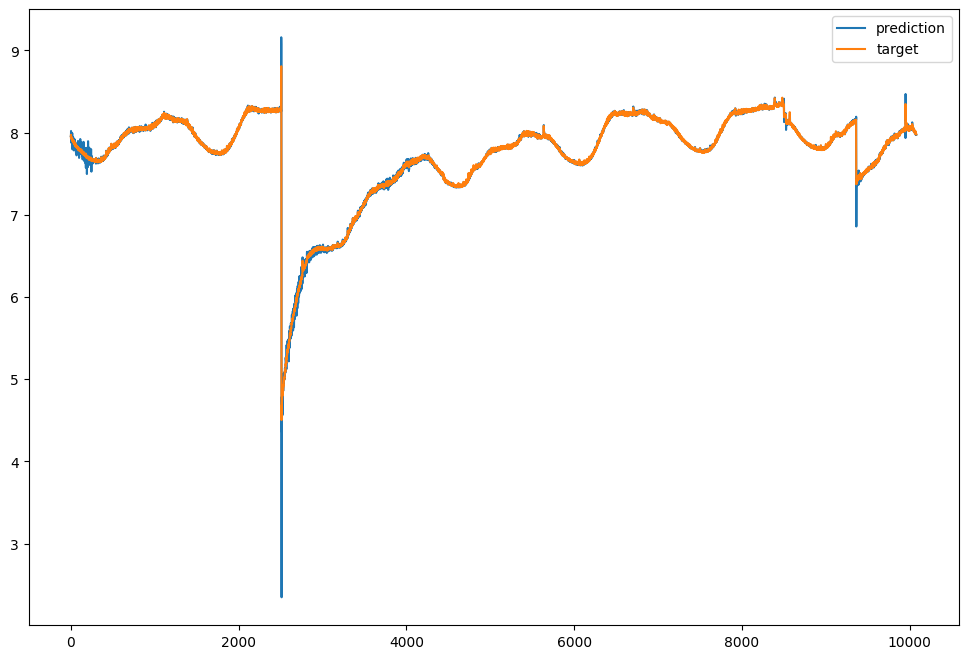

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([7.95394182, 7.95278692, 8.01867008, ..., 7.98008919, 7.98033619,
       7.97367048])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[7.941656],
       [7.972712],
       [7.94328 ],
       ...,
       [7.980072],
       [7.974312],
       [7.976136]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 0.1967930467799306 %
RMSE 0.04843045771121979
MAPE 0.19675467628985643 %


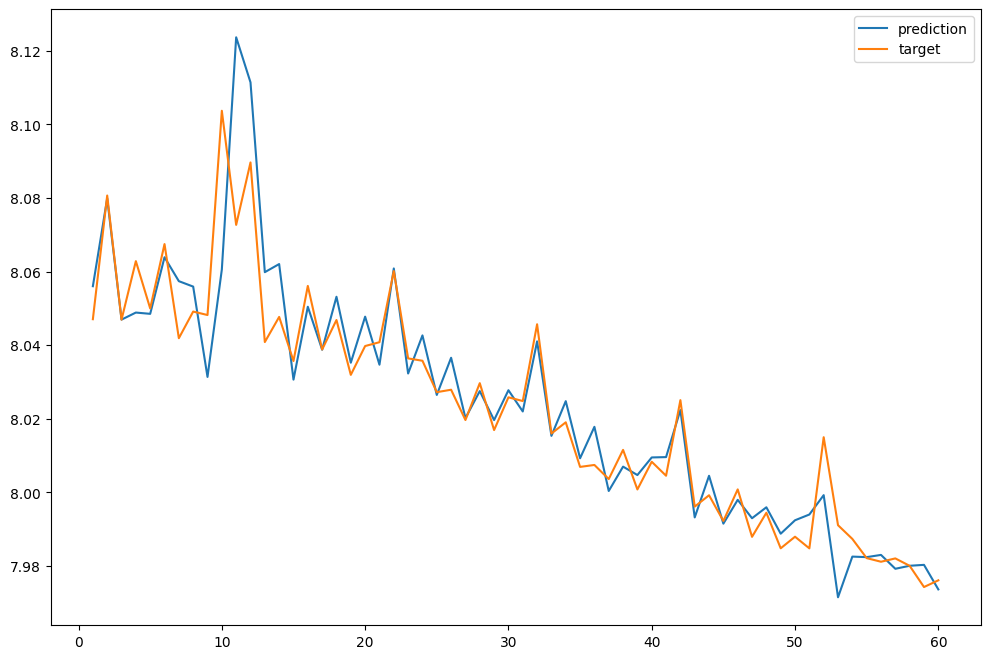

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.4178856767832287